# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

1. Installing and Importing Python Libraries and Dependencies

In [1]:
import pandas as pd
import requests

In [2]:
import numpy as np
!conda install -c conda-forge geocoder --yes
import geocoder
from geopy.geocoders import Nominatim 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geocoder:        1.38.1-py_1       conda-forge
    python_abi:    

In [3]:
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("All Required Libraries Imported!")

All Required Libraries Imported!


In [4]:
!conda install -c conda-forge folium
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          87 KB

The following NEW packages will be INSTALLED:

    branca: 0.4.1-py_0  conda-forge
    folium: 0.11.0-py_0 conda-forge


branca-0.4.1         | 26 KB     | ##################################### | 100% 
folium-0.11.0        | 61 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


2.  Data Extraction and Cleaning"

In [12]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [13]:
column_names = ['Postalcode','Borough','Neighborhood']

toronto = pd.DataFrame(columns = column_names)
content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2:
            neighborhood = td.text.strip('\\n').replace(']','')
            toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [17]:
# clean dataframe
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [18]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge\n"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek\n"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill\n"
4,M1G\n,Scarborough\n,Woburn\n


In [19]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M6W\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [20]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [21]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge\n"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek\n"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill\n"
4,M1G\n,Scarborough\n,Woburn\n


In [22]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [23]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M6W\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [24]:
print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge\n"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek\n"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill\n"
4,M1G\n,Scarborough\n,Woburn\n


In [25]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [28]:
# Retrieving Postal Code Co-ordinates
print("checkpt1")
postal_codes = df_2['Postalcode']
print("checkpt2")
coords = [get_latilong(postal_code) for postal_code in postal_codes.tolist()]
print("checkpt3")

checkpt1
checkpt2
checkpt3


In [29]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [30]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [31]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544
1,M1B\n,Scarborough\n,"Malvern, Rouge\n",43.81153,-79.19552
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek\n",43.78564,-79.15871
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill\n",43.76575,-79.17520
4,M1G\n,Scarborough\n,Woburn\n,43.76820,-79.21761
5,M1H\n,Scarborough\n,Cedarbrae\n,43.76969,-79.23944
6,M1J\n,Scarborough\n,Scarborough Village\n,43.74309,-79.23526
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park\n",43.72861,-79.26367
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge\n",43.71406,-79.28412
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West\n",43.72360,-79.23496


In [32]:
address = 'Scarborough,Toronto'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


### 3. Map of Scarborough

In [38]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)
map_Scarborough

In [39]:
address = 'Scarborough,Toronto'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [41]:
# @hiddel_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentials:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentials:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [43]:
radius = 700
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    latitude_n1,
    longitude_n1,
    radius,
    LIMIT)
results = requests.get(url).json()

In [44]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [45]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [46]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069


### 5. Categories of Nearby Venues/Locations

In [50]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split()[-1] for col in nearby_venues.columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069


In [58]:
# Top 10 Categories
a=pd.Series(nearby_venues.columns)
a.value_counts()[:10]

venue.location.lat    1
venue.name            1
venue.location.lng    1
venue.categories      1
dtype: int64

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat,
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in venue_results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']
    return(nearby_venues)

In [66]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Not assigned

Malvern, Rouge

Rouge Hill, Port Union, Highland Creek

Guildwood, Morningside, West Hill

Woburn

Cedarbrae

Scarborough Village

Kennedy Park, Ionview, East Birchmount Park

Golden Mile, Clairlea, Oakridge

Cliffside, Cliffcrest, Scarborough Village West

Birch Cliff, Cliffside West

Dorset Park, Wexford Heights, Scarborough Town Centre

Wexford, Maryvale

Agincourt

Clarks Corners, Tam O'Shanter, Sullivan

Milliken, Agincourt North, Steeles East, L'Amoreaux East

Steeles West, L'Amoreaux West

Upper Rouge

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Hillcrest Village

Fairview, Henry Farm, Oriole

Bayview Village

York Mills, Silver Hills

Willowdale, Newtonbrook

Willowdale, Willowdale East

York Mills West

Willowdale, Willowdale West

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Parkwoods

Don Mills

Don Mills

Not assigned

Not assigned

Bathurst Manor, Wilson

In [67]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 301 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt\n,30,30,30,30,30,30
"Alderwood, Long Branch\n",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North\n",4,4,4,4,4,4
Bayview Village\n,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East\n",28,28,28,28,28,28


### One Hot Encoding of Features

In [79]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix= "", prefix_sep= "")
# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / 

In [85]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)),
    print('\\')

---- Agincourt
 ----
                venue  freq
0  Chinese Restaurant  0.13
1       Shopping Mall  0.07
2    Department Store  0.03
3     Badminton Court  0.03
4     Bubble Tea Shop  0.03
\
---- Alderwood, Long Branch
 ----
            venue  freq
0      Print Shop  0.11
1     Pizza Place  0.11
2     Gas Station  0.11
3             Gym  0.11
4  Sandwich Place  0.11
\
---- Bathurst Manor, Wilson Heights, Downsview North
 ----
                  venue  freq
0                  Park  0.50
1     Convenience Store  0.25
2  Other Great Outdoors  0.25
3           Music Venue  0.00
4       Organic Grocery  0.00
\
---- Bayview Village
 ----
                     venue  freq
0                     Park  0.25
1                  Dog Run  0.25
2                    Trail  0.25
3         Asian Restaurant  0.25
4  New American Restaurant  0.00
\
---- Bedford Park, Lawrence Manor East
 ----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.07
2          Restaurant  0.07
3  I

In [86]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [87]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']
for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt\n,Chinese Restaurant,Shopping Mall,Malay Restaurant,Café,Supermarket,Sushi Restaurant,Sandwich Place,Mediterranean Restaurant,Bank,Bakery
1,"Alderwood, Long Branch\n",Dance Studio,Gas Station,Print Shop,Pub,Pizza Place,Pharmacy,Coffee Shop,Gym,Sandwich Place,Yoga Studio
2,"Bathurst Manor, Wilson Heights, Downsview North\n",Park,Other Great Outdoors,Convenience Store,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
3,Bayview Village\n,Park,Asian Restaurant,Trail,Dog Run,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East\n",Coffee Shop,Pizza Place,Sandwich Place,Restaurant,Italian Restaurant,Pet Store,Butcher,Pharmacy,Café,Sports Club


### K-Means Clustering Approach

In [88]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [89]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Scarborough_merged =df_2.iloc[:16,:]
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood\n",
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544,1,Coffee Shop,Hotel,Café,Italian Restaurant,Gym,Beer Bar,Restaurant,Bar,Japanese Restaurant,Gastropub
1,M1B\n,Scarborough\n,"Malvern, Rouge\n",43.81153,-79.19552,1,Zoo Exhibit,Fast Food Restaurant,Business Service,Construction & Landscaping,Hobby Shop,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek\n",43.78564,-79.15871,2,Fish & Chips Shop,Bar,Yoga Studio,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill\n",43.76575,-79.17520,0,Park,Athletics & Sports,Gym / Fitness Center,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,M1G\n,Scarborough\n,Woburn\n,43.76820,-79.21761,1,Park,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


### Map of Clusters

In [90]:
kclusters = 10

In [91]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'],
                                   Scarborough_merged['Longitude'],
                                   Scarborough_merged['Neighborhood'],
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [92]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [131]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                          "Average_Housing_Price":
                                           [335000.0,286600.0,175000.0,225900.0,219400.0,
                                            573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                            279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                            435000.0,289500.0,265000.0,285900.0,239400.0,
                                            589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                            229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                            573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                            279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                            573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                            279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                            573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                            279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                            573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                            279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,335000.0,286600.0,175000.0,225900.0,219400.0,
                                            573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                            279200.0,225000.0,370500.,255400.0,333500.0,433500.0,
                                            435000.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                            279200.0,375000.0,270500.,255400.0,493500.0,533500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                            273900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                            279200.0,195000.0,370500.,255400.0,403500.0,433500.0, 279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                            273900.0,329000.0,370500.0,370500.0,433500.0,479200.0,325000.0,370500.,255400.0,433500.0,433500.0,
                                            235000.0,289500.0,265000.0,285900.0,239400.0,
                                            389900.0,295000.0,380500.0,378500.0
                                                              ]})

In [132]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

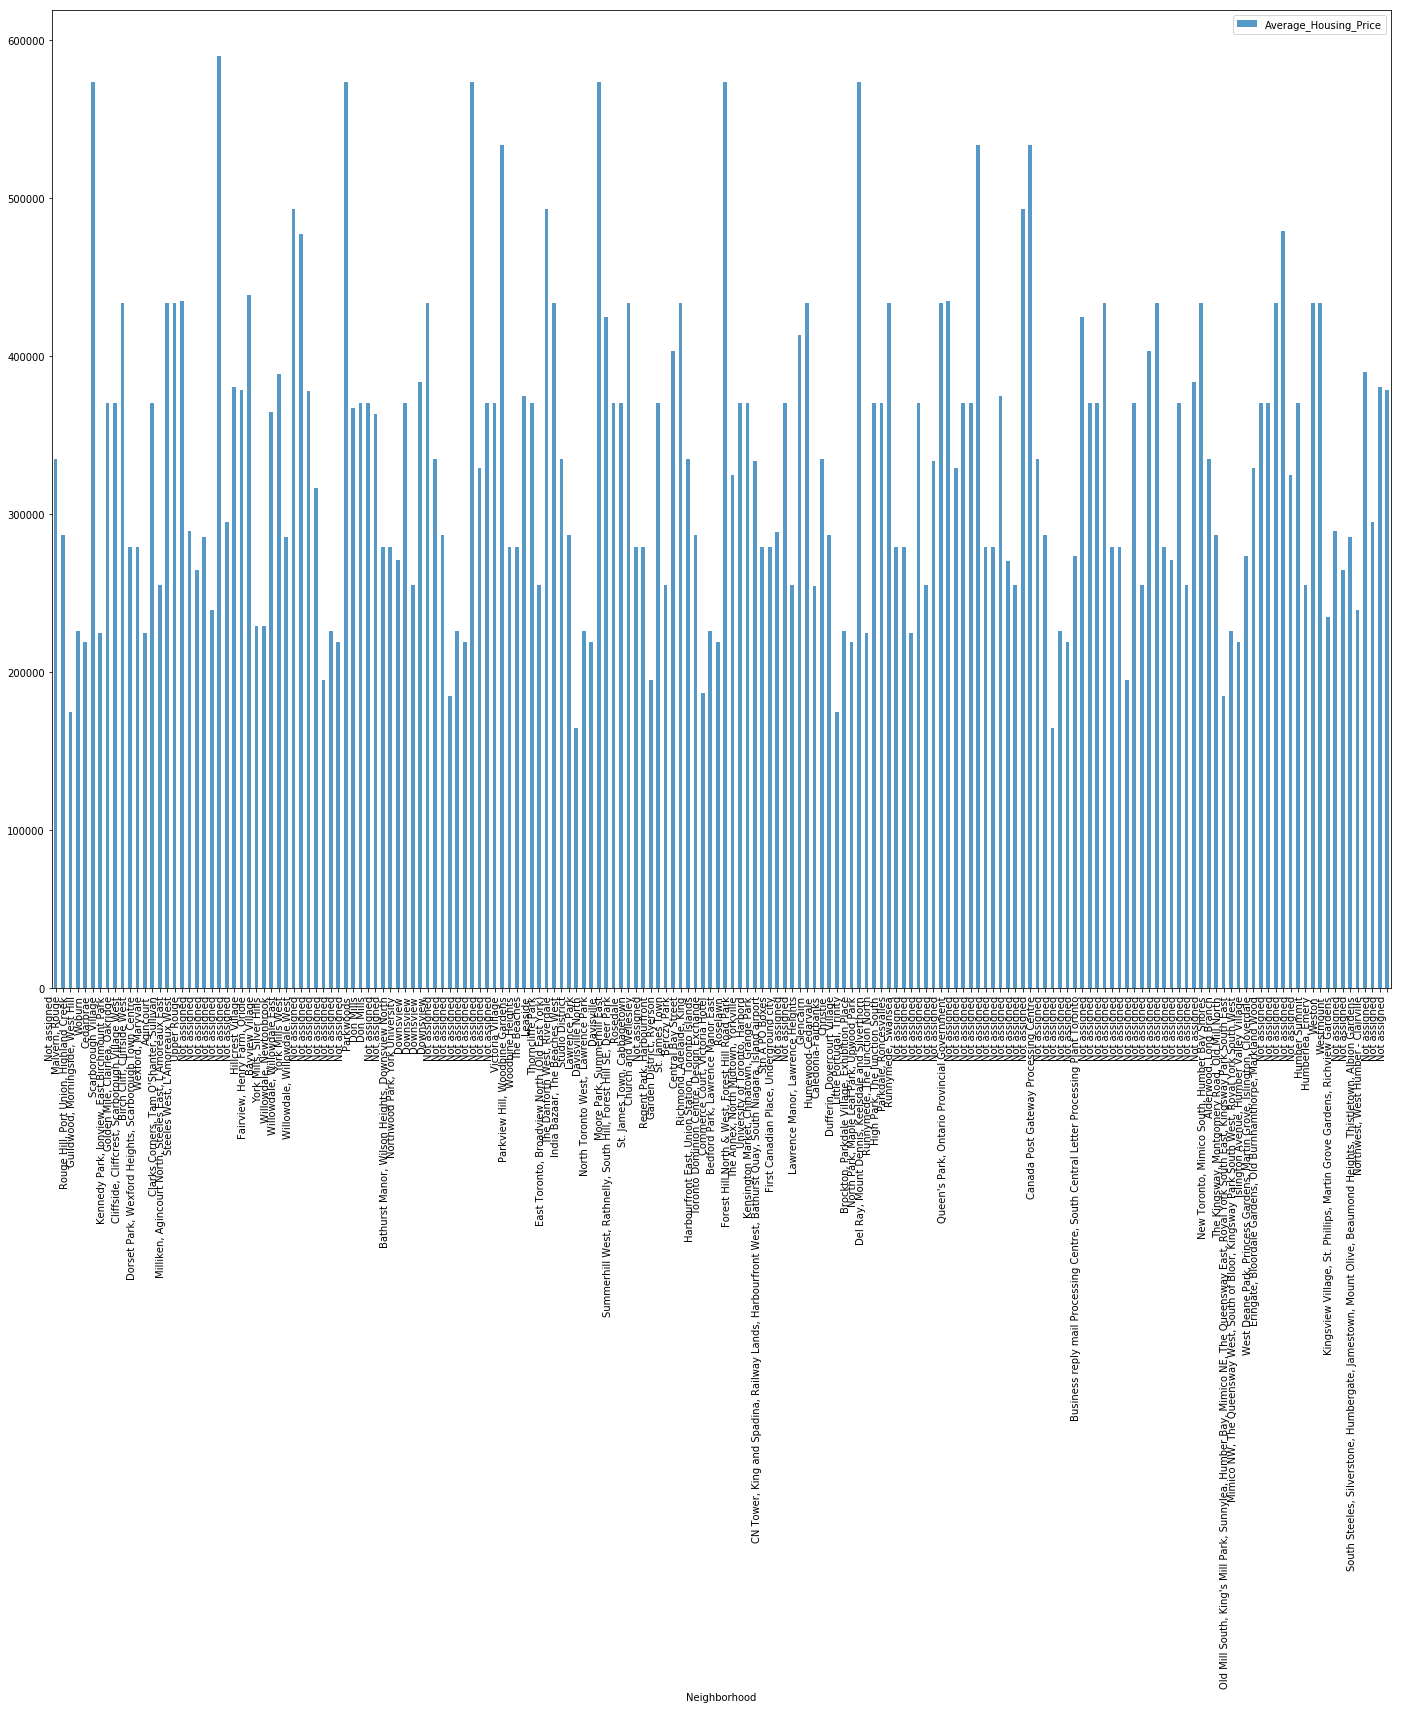

In [133]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [134]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [139]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,3,8,5,6,8,7,9,7,6,4,5,7,6,9,7,8,9,8,7,6,5,6,5,6,5,8,7,8,6,5,8,5,6,9,4,5,5,7,5,6,3,2,3,1,7,5,3,5,4,3,7,5,5,4,9,7,8,1,4,3,2,7,4,8,2,6,3,7,4,4,9,1,4,3,2,5,8
                                                           ]})

In [140]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

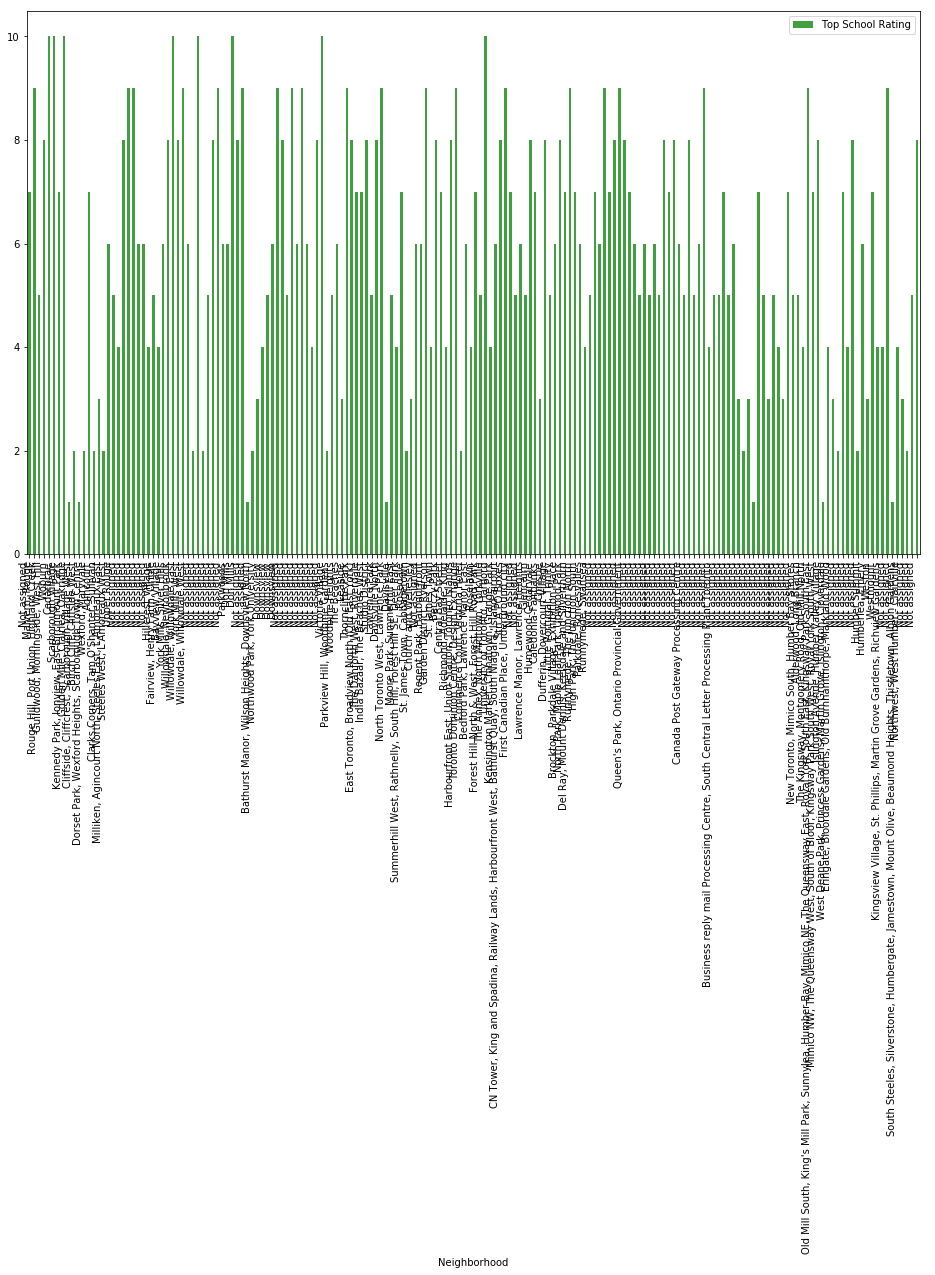

In [141]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75)

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.